In [20]:
import sys

import numpy as np
from qiskit_aer import Aer
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_algorithms import SciPyRealEvolver, TimeEvolutionProblem

import hamiltonian_simulation_kernel as ham
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import SparsePauliOp, hellinger_distance, hellinger_fidelity

import matplotlib.pyplot as plt
from qiskit_aer.primitives import Sampler
from qiskit.visualization import plot_distribution

def initial_state(n_spins: int, initial_state: str = "checker") -> QuantumCircuit:
    """
    Initialize the quantum state.

    Dev note: This function is copy/pasted from HamiltonianSimulation.

    Args:
        n_spins (int): Number of spins (qubits).
        initial_state (str): The chosen initial state. By default applies the checkerboard state, but can also be set to "ghz", the GHZ state.

    Returns:
        QuantumCircuit: The initialized quantum circuit.
    """
    qc = QuantumCircuit(n_spins)

    if (
        initial_state.strip().lower() == "checkerboard"
        or initial_state.strip().lower() == "neele"
    ):
        # Checkerboard state, or "Neele" state
        for k in range(0, n_spins, 2):
            qc.x([k])
    elif initial_state.strip().lower() == "ghz":
        # GHZ state: 1/sqrt(2) (|00...> + |11...>)
        qc.h(0)
        for k in range(1, n_spins):
            qc.cx(k - 1, k)

    return qc


def construct_TFIM_hamiltonian(n_spins: int) -> SparsePauliOp:
    """
    Construct the Transverse Field Ising Model (TFIM) Hamiltonian.

    Args:
        n_spins (int): Number of spins (qubits).

    Returns:
        SparsePauliOp: The Hamiltonian represented as a sparse Pauli operator.
    """
    pauli_strings = []
    coefficients = []
    g = 1  # Strength of the transverse field

    # Pauli spin vector product terms
    for i in range(n_spins):
        x_term = "I" * i + "X" + "I" * (n_spins - i - 1)
        pauli_strings.append(x_term)
        coefficients.append(g)

    identity_string = ["I"] * n_spins

    # ZZ operation on each pair of qubits in a linear chain
    for j in range(2):
        for i in range(j % 2, n_spins - 1, 2):
            zz_term = identity_string.copy()
            zz_term[i] = "Z"
            zz_term[(i + 1) % n_spins] = "Z"
            zz_term = "".join(zz_term)
            pauli_strings.append(zz_term)
            coefficients.append(1.0)

    return SparsePauliOp.from_list(zip(pauli_strings, coefficients))


def construct_heisenberg_hamiltonian(
    n_spins: int, w: int, hx: list[float], hz: list[float]
) -> SparsePauliOp:
    """
    Construct the Heisenberg Hamiltonian with disorder.

    Args:
        n_spins (int): Number of spins (qubits).
        w (float): Strength of two-qubit interactions for heisenberg hamiltonian.
        hx (list[float]): Strength of internal disorder parameter for heisenberg hamiltonian.
        hz (list[float]): Strength of internal disorder parameter for heisenberg hamiltonian.

    Returns:
        SparsePauliOp: The Hamiltonian represented as a sparse Pauli operator.
    """

    pauli_strings = []
    coefficients = []

    # Disorder terms
    for i in range(n_spins):
        x_term = "I" * i + "X" + "I" * (n_spins - i - 1)
        z_term = "I" * i + "Z" + "I" * (n_spins - i - 1)
        pauli_strings.append(x_term)
        coefficients.append(w * hx[i])
        pauli_strings.append(z_term)
        coefficients.append(w * hz[i])

    identity_string = ["I"] * n_spins

    # Interaction terms
    for j in range(2):
        for i in range(j % 2, n_spins - 1, 2):
            xx_term = identity_string.copy()
            yy_term = identity_string.copy()
            zz_term = identity_string.copy()

            xx_term[i] = "X"
            xx_term[(i + 1) % n_spins] = "X"

            yy_term[i] = "Y"
            yy_term[(i + 1) % n_spins] = "Y"

            zz_term[i] = "Z"
            zz_term[(i + 1) % n_spins] = "Z"

            pauli_strings.append("".join(xx_term))
            coefficients.append(1.0)
            pauli_strings.append("".join(yy_term))
            coefficients.append(1.0)
            pauli_strings.append("".join(zz_term))
            coefficients.append(1.0)

    return SparsePauliOp.from_list(zip(pauli_strings, coefficients))


def construct_hamiltonian(
    n_spins: int, hamiltonian: str, w: float, hx: list[float], hz: list[float]
) -> SparsePauliOp:
    """
    Construct the Hamiltonian based on the specified method.

    Args:
        n_spins (int): Number of spins (qubits).
        hamiltonian (str): Which hamiltonian to run. "heisenberg" by default but can also choose "TFIM".
        w (float): Strength of two-qubit interactions for heisenberg hamiltonian.
        hx (list[float]): Strength of internal disorder parameter for heisenberg hamiltonian.
        hz (list[float]): Strength of internal disorder parameter for heisenberg hamiltonian.

    Returns:
        SparsePauliOp: The constructed Hamiltonian.
    """

    hamiltonian = hamiltonian.strip().lower()

    if hamiltonian == "heisenberg":
        return construct_heisenberg_hamiltonian(n_spins, w, hx, hz)
    elif hamiltonian == "tfim":
        return construct_TFIM_hamiltonian(n_spins)
    else:
        raise ValueError("Invalid Hamiltonian specification.")


def HamiltonianSimulationExact(
    n_spins: int,
    t: float,
    init_state: str,
    hamiltonian: str,
    w: float,
    hx: list[float],
    hz: list[float],
) -> dict:
    """
    Perform exact Hamiltonian simulation using classical matrix evolution.

    Args:
        n_spins (int): Number of spins (qubits).
        t (float): Duration of simulation.
        init_state (str): The chosen initial state. By default applies the checkerboard state, but can also be set to "ghz", the GHZ state.
        hamiltonian (str): Which hamiltonian to run. "heisenberg" by default but can also choose "TFIM".
        w (float): Strength of two-qubit interactions for heisenberg hamiltonian.
        hx (list[float]): Strength of internal disorder parameter for heisenberg hamiltonian.
        hz (list[float]): Strength of internal disorder parameter for heisenberg hamiltonian.

    Returns:
        dict: The distribution of the evolved state.
    """
    hamiltonian_sparse = construct_hamiltonian(n_spins, hamiltonian, w, hx, hz)
    time_problem = TimeEvolutionProblem(
        hamiltonian_sparse, t, initial_state=initial_state(n_spins, init_state)
    )
    result = SciPyRealEvolver(num_timesteps=1).evolve(time_problem)
    return result.evolved_state.probabilities_dict()


def create_noise_model(fidelity):

    if fidelity == 1:
        return None
    else:
        p = 15 / 4 * (1 - fidelity)
        noise_model = NoiseModel()
        depolarizing_err = depolarizing_error(p, 2)  # 2-qubit depolarizing error
        noise_model.add_all_qubit_quantum_error(
            depolarizing_err, ["cx"]
        )  # Apply to CNOT gates
        return noise_model



def get_probability_distribution(circuit, shots=None):
    """
    Generates the probability distribution of the outcomes for a given Qiskit circuit.

    Parameters:
    - circuit (QuantumCircuit): The quantum circuit to simulate.
    - shots (int): The number of shots for the simulation.

    Returns:
    - result (dict): The probability distribution of the outcomes.
    """

    sampler = Sampler()

    # shots = None means the results will be exact?
    result = sampler.run(circuit, shots=shots).result()

    dist = result.quasi_dists[0].binary_probabilities()

    return dist


def get_init_state_distribution(n_spins, hamiltonian):

    if hamiltonian.lower().strip() == "tfim":
        init_state = "ghz"
    else:
        init_state = "checkerboard"

    init_circ = ham.initial_state(n_spins, init_state)

    init_circ.measure_all()

    return get_probability_distribution(init_circ)


def get_dist_at_timestep(step, K, max_time, hamiltonian, w, hx, hz):

    if step == 0:
        return get_init_state_distribution(n_spins=6, hamiltonian=hamiltonian)
    else:
        return get_probability_distribution(
            ham.HamiltonianSimulation(
                n_spins=6,
                K=step,
                t=step * (max_time / K),
                hamiltonian=hamiltonian,
                w=w,
                hx=hx,
                hz=hz,
            )
        )


In [21]:
# produce four plots.
#
# Plot #1: Hellinger distance from initial state using quantum trotterization steps.
# Plot #2: Hellinger distance from initial state using exact classical calculation (can use many more little time steps.)
# Plot #3: Combine plots #1 and #2 onto the same axis.
# Plot #4: Hellinger fidelity at each time step from the classical exact to the trotterized at each time step.
# All four of these plots will be saved onto the computer into the working directory.

np.random.seed(26)
hx = list(2 * np.random.random(20) - 1)  # random numbers between [-1, 1]
np.random.seed(75)
hz = list(2 * np.random.random(20) - 1)  # random numbers between [-1, 1]
w = 1
K = 10

hamiltonians_initstate_pairs = [("heisenberg", "checkerboard"), ("tfim", "ghz")]

# add switching bewteen different total times in the future?
max_time = 0.4

image_label_raw = f"maxtime {max_time}"
image_label = image_label_raw.replace(".", "dot").replace(" ", "_")

In [ ]:
# Plot #1: Hellinger distance from initial state using quantum trotterization steps.

for hamiltonian, init_state in hamiltonians_initstate_pairs:

    hellingers = []
    times = []
    initial_distribution = None

    for k_i in range(K + 1):
        # note k_0 = 0
        #
        dist = get_dist_at_timestep(k_i, K, max_time, hamiltonian, w, hx, hz)

        if k_i == 0:
            first_dist = dist

        hellingers.append(hellinger_distance(first_dist, dist))
        times.append(k_i * (max_time / K))

    plt.plot(times, hellingers, marker="o")
plt.title(
    "Hellinger distance from initial state VS time for quantum trotterization steps"
)
plt.legend(["trotterized heisenberg", "trotterized tfim"])
plt.xlabel("Time")
plt.ylabel("Hellinger distance")
plt.show(image_label + "plot1")

In [ ]:
# Plot #2: Hellinger distance from initial state using exact classical calculation (can use many more little time steps.)

for hamiltonian, init_state in hamiltonians_initstate_pairs:
    hellinger_list = []
    first_exact = None

    for t in np.linspace(0, max_time, 100):

        exact_dist = HamiltonianSimulationExact(
            6, t, init_state=init_state, hamiltonian=hamiltonian, w=1, hx=hx, hz=hz
        )

        if t == 0:
            first_exact = exact_dist

        dist = hellinger_distance(first_exact, exact_dist)
        hellinger_list.append(dist)

    plt.plot([t for t in np.linspace(0, max_time, 100)], hellinger_list)
plt.title(
    image_label_raw
    + "\n"
    + "Hellinger distance from initial state for exact evolution VS time"
)
plt.legend(["exact heisenberg", "exact tfim"])
plt.xlabel("Time")
plt.ylabel("Hellinger distance")
plt.show()

In [ ]:
# Plot #3: Combine plots #1 and #2 onto the same axis.

for hamiltonian, init_state in hamiltonians_initstate_pairs:

    hellingers = []
    times = []
    initial_distribution = None

    for k_i in range(K + 1):
        # note k_0 = 0

        dist = get_dist_at_timestep(k_i, K, max_time, hamiltonian, w, hx, hz)

        if k_i == 0:
            first_dist = dist

        hellingers.append(hellinger_distance(first_dist, dist))
        times.append(k_i * (max_time / K))

    plt.plot(times, hellingers, marker="o")

for hamiltonian, init_state in hamiltonians_initstate_pairs:
    hellinger_list = []
    first_exact = None

    for t in np.linspace(0, max_time, 100):

        exact_dist = HamiltonianSimulationExact(
            6, t, init_state=init_state, hamiltonian=hamiltonian, w=1, hx=hx, hz=hz
        )

        if t == 0:
            first_exact = exact_dist

        dist = hellinger_distance(first_exact, exact_dist)
        hellinger_list.append(dist)

    plt.plot([t for t in np.linspace(0, max_time, 100)], hellinger_list)
plt.title(image_label_raw + "\n" + "Hellinger distance from initial state VS time")
plt.legend(
    ["trotterized heisenberg", "trotterized tfim", "exact heisenberg", "exact tfim"]
)
plt.xlabel("Time")
plt.ylabel("Hellinger distance")
plt.show()

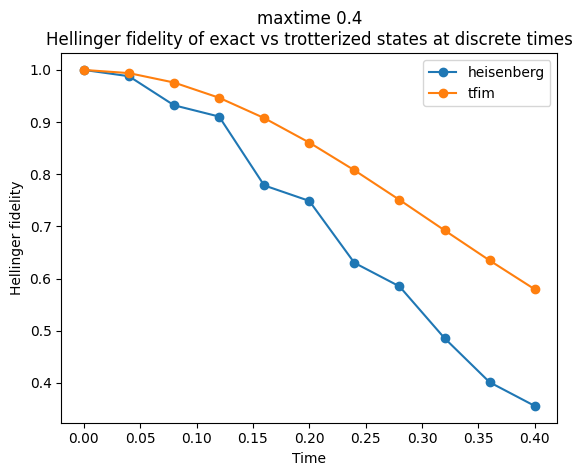

In [24]:
# Plot #4: Hellinger fidelity at each time step from the classical exact to the trotterized at each time step.

for hamiltonian, init_state in hamiltonians_initstate_pairs:
    hellingers = []
    times = []
    initial_distribution = None

    for k_i in range(K + 1):
        # note k_0 = 0
        #
        dist = get_dist_at_timestep(k_i, K, max_time, hamiltonian, w, hx, hz)

        exact_dist = HamiltonianSimulationExact(
            6,
            t=k_i * (max_time / K),
            init_state=init_state,
            hamiltonian=hamiltonian,
            w=1,
            hx=hx,
            hz=hz,
        )

        hellingers.append(hellinger_fidelity(exact_dist, dist))
        times.append(k_i * (max_time / K))

    plt.plot(times, hellingers, marker="o")
plt.title(
    image_label_raw
    + "\n"
    + "Hellinger fidelity of exact vs trotterized states at discrete times"
)
plt.legend(["heisenberg", "tfim"])
plt.xlabel("Time")
plt.ylabel("Hellinger fidelity")
plt.show()

https://arxiv.org/abs/1912.08854:

**Proposition 15 (Tight error bound for the first-order Lie-Trotter formula).**
Let $H = \sum_{\gamma=1}^{\Gamma} H_\gamma$ be a Hamiltonian consisting of $\Gamma$ summands and $t \geq 0$.
Let $\mathcal{S}_1(t) = \prod_{\gamma=1}^{\Gamma} e^{-itH_\gamma}$ be the first-order Lie-Trotter formula.
Then, the additive Trotter error can be bounded as

$$
\left\| \mathcal{S}_1(t) - e^{-itH} \right\| \leq \frac{t^2}{2} \left\| \sum_{\gamma_1=1}^{\Gamma} \left[ \sum_{\gamma_2=\gamma_1+1}^{\Gamma} [H_{\gamma_2}, H_{\gamma_1}] \right] \right\|.
$$

Given this, we can plot this error for both of our Hamiltonians and compare it to the maximum amount of error that they should be having.

In [61]:
from qiskit.quantum_info import Statevector, state_fidelity, commutator

def max_trotter_error(ham, max_time):
    """
    Following the Childs et al. paper, calculate the maximum error for the order 1 Lie-Trotter trotterization. 
    """

    Gamma = len(ham)

    commutators = []

    for gamma_1 in range(Gamma):
        for gamma_2 in range(gamma_1+1, Gamma): 

            commutators.append(commutator(ham[gamma_2], ham[gamma_1]))

    spectral_norm = np.linalg.norm(sum(commutators).to_matrix(), ord=2)

    return max_time**2 * (1/2) * spectral_norm 

            

In [63]:
for max_time in range(10):
    print(max_trotter_error(construct_hamiltonian(6, "tfim", w, hx, hz), max_time))

#0.0
4.472135954999579
17.888543819998315
40.24922359499621
71.55417527999326
111.80339887498947
160.99689437998484
219.13466179497937
286.21670111997304
362.24301235496586



0.0
6.987918414869866
27.951673659479464
62.891265733828796
111.80669463791786
174.69796037174666
251.56506293531518
342.4080023286234
447.22677855167143
566.0213916044592


362.24301235496586

In [55]:
def HamiltonianSimulationExactVector(
    n_spins: int,
    t: float,
    init_state: str,
    hamiltonian: str,
    w: float,
    hx: list[float],
    hz: list[float],
) -> dict:
    """
    Perform exact Hamiltonian simulation using classical matrix evolution.

    Args:
        n_spins (int): Number of spins (qubits).
        t (float): Duration of simulation.
        init_state (str): The chosen initial state. By default applies the checkerboard state, but can also be set to "ghz", the GHZ state.
        hamiltonian (str): Which hamiltonian to run. "heisenberg" by default but can also choose "TFIM".
        w (float): Strength of two-qubit interactions for heisenberg hamiltonian.
        hx (list[float]): Strength of internal disorder parameter for heisenberg hamiltonian.
        hz (list[float]): Strength of internal disorder parameter for heisenberg hamiltonian.

    Returns:
        dict: The distribution of the evolved state.
    """
    hamiltonian_sparse = construct_hamiltonian(n_spins, hamiltonian, w, hx, hz)
    time_problem = TimeEvolutionProblem(
        hamiltonian_sparse, t, initial_state=initial_state(n_spins, init_state)
    )
    result = SciPyRealEvolver(num_timesteps=1).evolve(time_problem)
    return result.evolved_state

def get_init_state_distribution_vector(n_spins, hamiltonian):

    if hamiltonian.lower().strip() == "tfim":
        init_state = "ghz"
    else:
        init_state = "checkerboard"

    init_circ = ham.initial_state(n_spins, init_state)

    return get_vector(init_circ)


def get_vector_at_timestep(n_qubits,step, K, max_time, hamiltonian, w, hx, hz):

    if step == 0:
        return get_init_state_distribution_vector(n_spins=n_qubits, hamiltonian=hamiltonian)
    else:
        return get_vector(
            ham.HamiltonianSimulation(
                n_spins=n_qubits,
                K=step,
                t=step * (max_time / K),
                hamiltonian=hamiltonian,
                w=w,
                hx=hx,
                hz=hz,
            ).remove_final_measurements(inplace=False)
        )

def get_vector(circuit, shots=None):
    """
    Generates the probability distribution of the outcomes for a given Qiskit circuit.

    Parameters:
    - circuit (QuantumCircuit): The quantum circuit to simulate.
    - shots (int): The number of shots for the simulation.

    Returns:
    - result (dict): The probability distribution of the outcomes.
    """

    return Statevector(circuit)


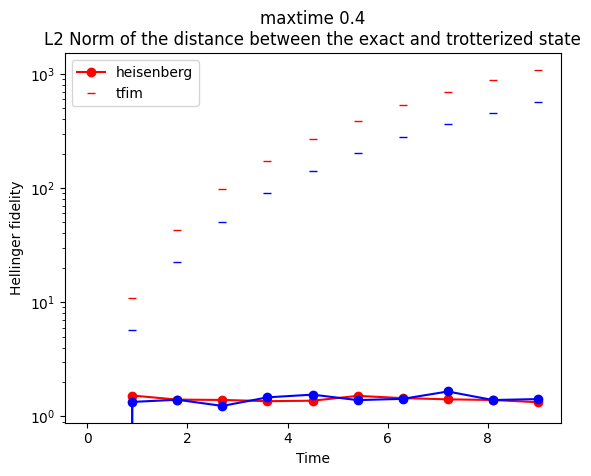

In [60]:
# Plot #4: Hellinger fidelity at each time step from the classical exact to the trotterized at each time step.

n_qubit = 6

colors = ['r','b']

for i, (hamiltonian, init_state) in enumerate(hamiltonians_initstate_pairs):
    hellingers = []
    max_errors = []
    times = []
    initial_distribution = None

    for k_i in range(K + 1):
        # note k_0 = 0

        time = 
        
        max_error = max_trotter_error(construct_hamiltonian(n_qubit, hamiltonian, w, hx, hz), k_i * (max_time / K))
        max_errors.append(max_error)
        
        vector = get_vector_at_timestep(n_qubit, k_i, K, max_time, hamiltonian, w, hx, hz)

        exact_vector = HamiltonianSimulationExactVector(
            n_qubit,
            t=k_i * (max_time / K),
            init_state=init_state,
            hamiltonian=hamiltonian,
            w=1,
            hx=hx,
            hz=hz,
        )

        #doing .data just gets the 1D statevectors... I think. Since these are pure states.
        
        hellingers.append(np.linalg.norm((vector.data- exact_vector.data), ord=2))
        times.append(k_i * (max_time / K))

    plt.plot(times, hellingers, marker="o", color = colors[i])
    plt.plot(times, max_errors, marker="_", linestyle = '', color=colors[i])
plt.title(
    image_label_raw
    + "\n"
    + "L2 Norm of the distance between the exact and trotterized state"
)
plt.legend(["heisenberg", "tfim"])
plt.xlabel("Time")
plt.ylabel("Hellinger fidelity")
plt.yscale('log')
plt.show()